In [30]:
# load libraries
library(readr)
library (ggplot2)
library(purrr)
library(caret)
library(scales)
library(tibble)
install.packages("gplots")
library(gplots)

also installing the dependencies 'bitops', 'gtools', 'gdata', 'caTools'



package 'bitops' successfully unpacked and MD5 sums checked
package 'gtools' successfully unpacked and MD5 sums checked
package 'gdata' successfully unpacked and MD5 sums checked
package 'caTools' successfully unpacked and MD5 sums checked
package 'gplots' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\xinli\AppData\Local\Temp\Rtmp6TPeuO\downloaded_packages


Warning message:
"package 'gplots' was built under R version 3.6.3"
Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess



In [3]:
#function to import dataframes and remove rows and columns with mostly empty cells
#Parameter: list of file names
#Returns: dataframe combining all files from list, excluding columns and rows more than half empty

import<-function(x){
  x<-x%>%map_dfr(read.csv)
  x<-x[rowSums(is.na(x))<ncol(x)*0.9,colSums(is.na(x))<nrow(x)*0.9]
  return (x)
}

In [4]:
#normalize function
#Parameter: dataframe to normalize
#Returns: normalized dataframe obtained by subtracting the mean of the variable and dividing the result 
#by the variable's standard deviation, first five columns are ignored because they contain information
#about the metadata of the features, and are not features themselves

normalize<-function(x){
  x<- subset(x, select=-c(Metadata_PositionX,Metadata_Series))
  x <- x[ - as.numeric(which(apply(x, 2, var) == 0))]
  x<-x[,colSums(is.na(x))<nrow(x)]
  x<-x[rowSums(is.na(x))<ncol(x)*0.5,]
  #x1<-x[,c(1:5)]
  #x2<- as.data.frame(scale(x[,c(6:ncol(x))]))
  #x<-cbind(x1, x2)
  return(x)
}

In [5]:
#metadata function
#Parameters: dataframe to reutrn, main dataframe (cells, nuclei, cytoplasm), columns corresponding to df's condition
#Returns: dataframe with only rows of specified condition

metadata<-function(df,main, x, y){
  df<-main%>% 
    filter(Metadata_PositionY==x|Metadata_PositionY==y)
  return(df)
}

In [6]:
#Shapiro- Wilks function
#Parameters: dataframe, threshold
#Returns: dataframe with only columns with W<threshold
shapiro<-function(df, threshold){
  df<- subset(df, select=-c(Metadata_Site))
  df<- df[ ,- as.numeric(which(apply(df, 2, var) == 0))]
  lshap <- lapply(df, shapiro.test)
  lres <- sapply(lshap, `[`, c("statistic","p.value"))
  lres<- as.data.frame(t(lres))
  lres<-lres[lres[,"p.value"]<threshold,]
  return (lres)
}

In [7]:
#Shapiro- Wilks function
#Parameters: dataframe, threshold
#Returns: dataframe with only columns with W>threshold
shapiro2<-function(df, threshold){
  df<- subset(df, select=-c(Metadata_Site))
  df<- df[ ,- as.numeric(which(apply(df, 2, var) == 0))]
  lshap <- lapply(df, shapiro.test)
  lres <- sapply(lshap, `[`, c("statistic","p.value"))
  lres<- as.data.frame(t(lres))
  lres<-lres[lres[,"p.value"]>threshold,]
  return (lres)
}

In [8]:
#Kolmogorov-Smirnov test function
#Parameters: dataframe
#Returns: dataframe with K-S stats and p values
ks2<-function(df){
  df<- subset(df, select=-c(Metadata_Site))
  df<- df[ ,- as.numeric(which(apply(df, 2, var) == 0))]
  lshap <- lapply(df, function(t,d1){ks.test(df,"pnorm")})
  lres <- sapply(lshap, `[`, c("statistic","p.value"))
  return (lres)
}

In [9]:
#diagnol correlation function
#parameters: longer dataframe, shorter dataframe, threshold for correlation, dataframes must have same columns
#output: a list of all columns which have a correlation coeffecient > threshold

diag2<-function(long, short, threshold){
  y<- average(long, short)
  corr<-cor(long, y)
  diag<-as.data.frame(diag(corr))
  diag<-subset(diag, diag$`diag(corr)`>threshold)
  return(diag)
}

In [10]:
#function that adds rows with the column's average so the shorter dataframe matches the dimensions of the 
#longer dataframe
#Parameter: two dataframes with the same number of columns
#Returns: the originally shorter dataframe with the additional rows
average<-function(longer,shorter){
  average<-as.data.frame.list(colMeans(shorter))
  average<-average%>% slice(rep(1, each=nrow(longer)-nrow(shorter)))
  shorter2<-rbind(average, shorter)
  return(shorter2)
}

In [11]:
#import feature dataframes and remove rows and columns with more than half empty cells
setwd("C:/Users/xinli/Desktop/Work/Spreadsheets/Features")
cells <- list.files(pattern="*Cells.csv")
cells <- import(cells)
cells<- normalize(cells)
cytoplasm <- list.files(pattern="*Cytoplasm.csv")
cytoplasm <-import(cytoplasm)
cytoplasm<- normalize(cytoplasm)
nuclei <- list.files(pattern="*Nuclei.csv")
nuclei <- import(nuclei)
nuclei<- normalize(nuclei)

In [17]:
#separate dataframes into experimental conditions 
control_cells<- metadata(control_cells, cells, 2, 11)
control_nuclei<- metadata(control_nuclei,nuclei, 2, 11)
control_cyto<-metadata(control_cyto, cytoplasm, 2, 11)

DMSO_cells<- metadata(DMSO_cells, cells, 3, 10)
DMSO_nuclei <- metadata (DMSO_nuclei, nuclei, 3,10)
DMSO_cytoplasm <- metadata(DMSO_cytoplasm, cytoplasm, 3, 10)

CHIR_cells<-metadata(CHIR_cells, cells, 5, 8)
CHIR_nuclei<-metadata(CHIR_nuclei, nuclei, 5,8)
CHIR_cytoplasm<-metadata (CHIR_cytoplasm, cytoplasm, 5, 8)

Rock_cells<-metadata(Rock_cells, cells, 4, 9)
Rock_nuclei<-metadata(Rock_nuclei, nuclei, 4, 9)
Rock_cytoplasm<-metadata(Rock_cytoplasm, cytoplasm, 4,9)

IWP_cells<-metadata(IWP_cells, cells, 6, 7)
IWP_nuclei<-metadata(IWP_nuclei, nuclei, 6, 7)
IWP_cytoplasm<-metadata(IWP_cytoplasm, cytoplasm, 6, 7)

In [35]:
# compute mean, median, variance for each cell feature
setwd("C:/Users/xinli/Desktop/Work/Spreadsheets/Features")
cells4 <- list.files(pattern="*Cells.csv")
cells4 <- import(cells4)

cells_mean<- aggregate(.~Metadata_Site, FUN=mean, data=cells4[,7:1385])
cells_median<- aggregate(.~Metadata_Site, FUN=median, data=cells4[,7:1385])
cells_var<- aggregate(.~Metadata_Site, FUN=var, data=cells4[,7:1385])
mean_var<-as.data.frame(sapply(cells_mean, var))

cells4<-within(cells,Metadata_PositionY[Metadata_PositionY==11]<-"control")
cells4<-within(cells,Metadata_PositionY[Metadata_PositionY==10]<-"DMSO")
cells4<-within(cells,Metadata_PositionY[Metadata_PositionY==8]<-"IWP")
cells4<-within(cells,Metadata_PositionY[Metadata_PositionY==7]<-"CHIR")

cells_mean2<- aggregate(.~Metadata_PositionY, FUN=mean, data=cells4)
cells_median2<- aggregate(.~Metadata_PositionY, FUN=median, data=cells4)
cells_var2<- aggregate(.~Metadata_PositionY, FUN=var, data=cells4)

In [40]:
ces <- data.frame(lapply(cells_median2[,-1], function(x) (x-min(x))/(max(x) - min(x)) * 10))
ces<-cbind(cells_median2[,1], ces)
rownames(ces) <- cells_median2[,1]

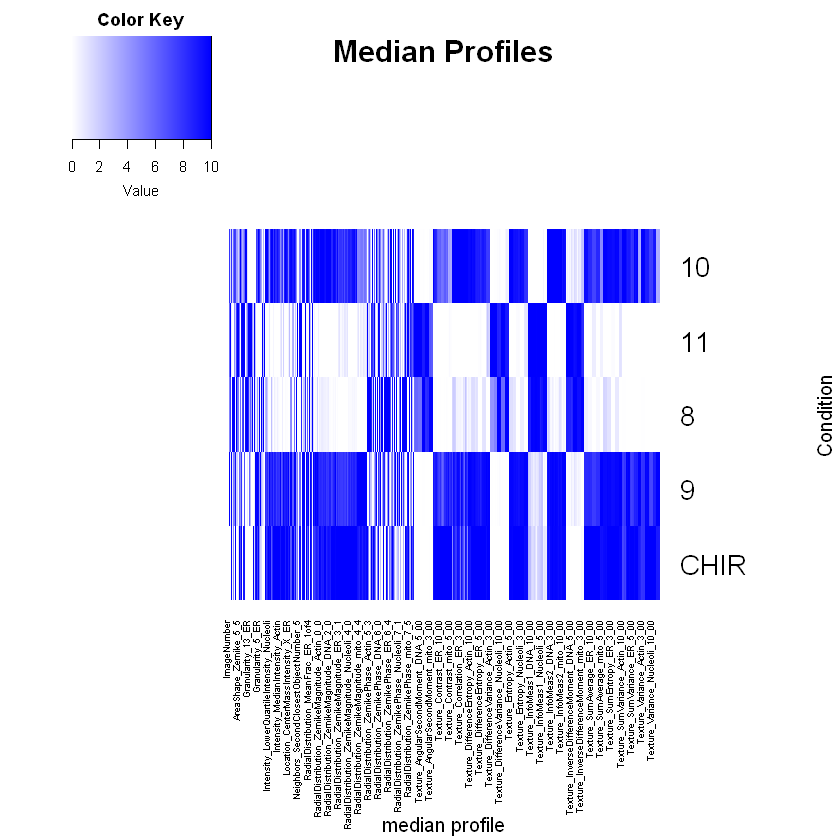

In [44]:
heatmap.2(as.matrix(ces[,2:ncol(ces)]), scale = "none", dendrogram='none', Rowv=FALSE, Colv=FALSE, 
col = colorpanel(1000, "white", "blue"), trace = "none", density.info = "none", 
xlab="median profile", ylab="Condition", main= "Median Profiles", margins = c(12,9))

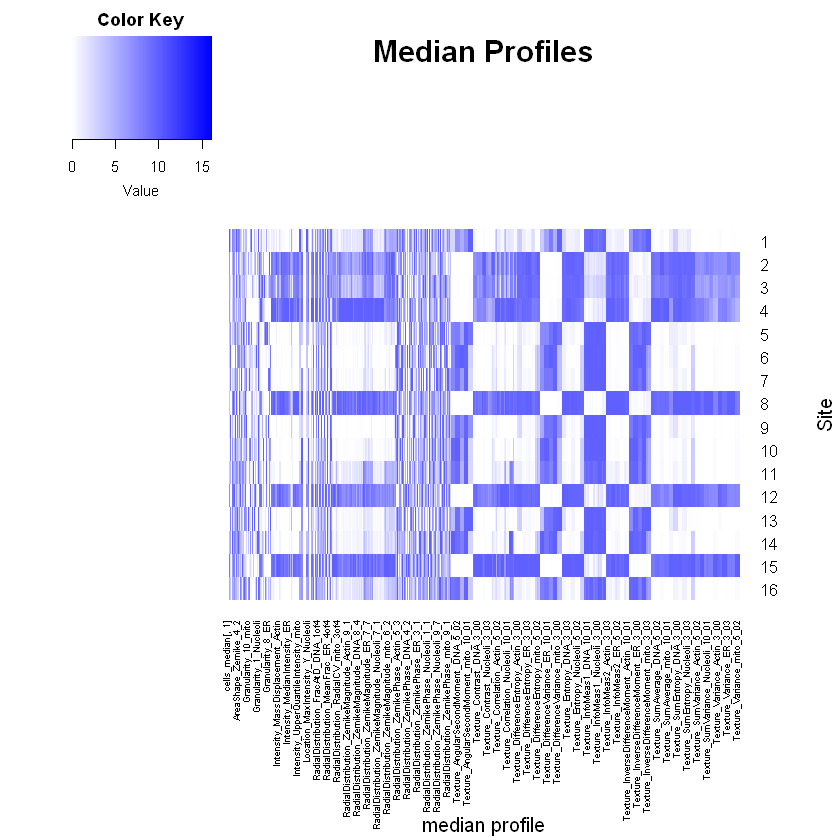

In [31]:
 #scale median dataframe to 0-10, create median profile heatmap
ces <- data.frame(lapply(cells_median[,-1], function(x) (x-min(x))/(max(x) - min(x)) * 10))
ces<-cbind(cells_median[,1], ces)
rownames(ces) <- cells_median[,1]
heatmap.2(as.matrix(ces), scale = "none", dendrogram='none', Rowv=FALSE, Colv=FALSE, 
          col = colorpanel(1000, "white", "blue"), trace = "none", density.info = "none", 
          xlab="median profile", ylab="Site", main= "Median Profiles", margins = c(12,5))

In [45]:
#compute features with averages that don't vary much across sites 
mean_var2<- mean_var %>%
  rownames_to_column('rownames') %>%
  filter(`sapply(cells_mean, var)`>1000) %>%
  column_to_rownames('rownames')

mean_var5<- mean_var3 %>%
  rownames_to_column('rownames') %>%
  filter(`sapply(cells_mean2, var)`>1000) %>%
  column_to_rownames('rownames')

In [46]:
#find correlation across sites
control_cells_site10<-control_cells%>%
  filter(Metadata_Site==10)
control_cells_site11<-control_cells%>%
  filter(Metadata_Site==11)
control_s10_vs_s11<-diag2(control_cells_site11, control_cells_site10, 0.6)

control_nuclei_site10<-control_nuclei%>%
  filter(Metadata_Site==10)
control_nuclei_site11<-control_nuclei%>%
  filter(Metadata_Site==11)
controlnuc_s10_vs_s11<-diag2(control_nuclei_site11, control_nuclei_site10, 0.6)

Warning message in cor(long, y):
"the standard deviation is zero"Warning message in cor(long, y):
"the standard deviation is zero"

In [47]:
#find correlation across conditions
DMSO_vs_control<-diag2(control_cells, DMSO_cells, 0.1)
DMSO_cells_s10<-DMSO_cells%>%
  filter(Metadata_Site==10)
DMSOs10vs_control<-diag2( control_cells_site10, DMSO_cells_s10, 0.1)

Warning message in cor(long, y):
"the standard deviation is zero"Warning message in cor(long, y):
"the standard deviation is zero"

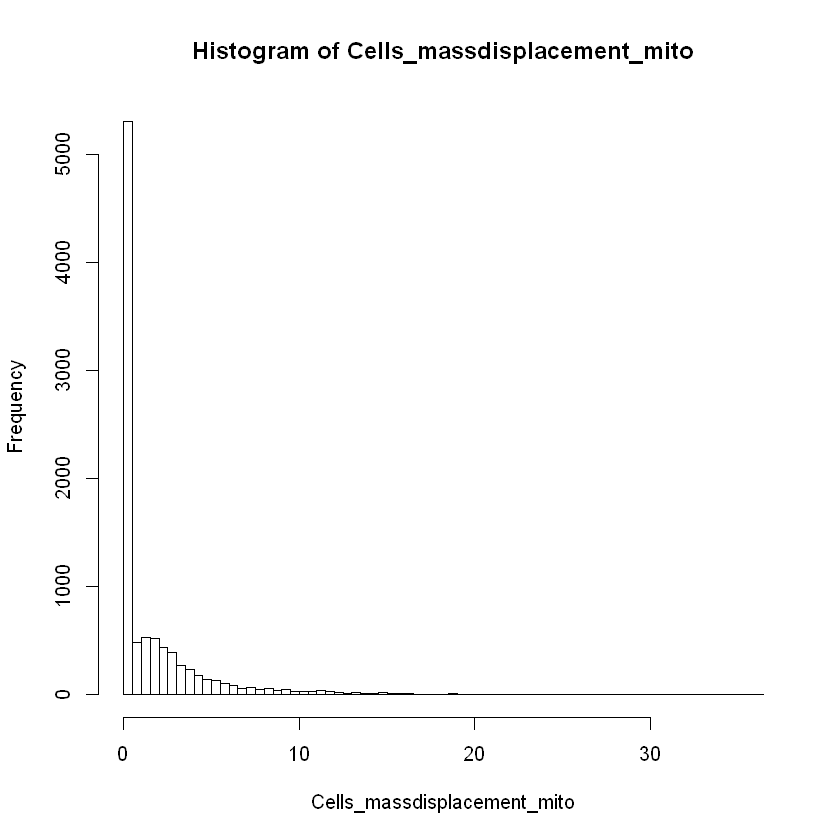

In [48]:
#create histograms of distributions for a few features
Cells_massdisplacement_mito<-cells$Intensity_MassDisplacement_mito
hist(Cells_massdisplacement_mito, breaks=100)

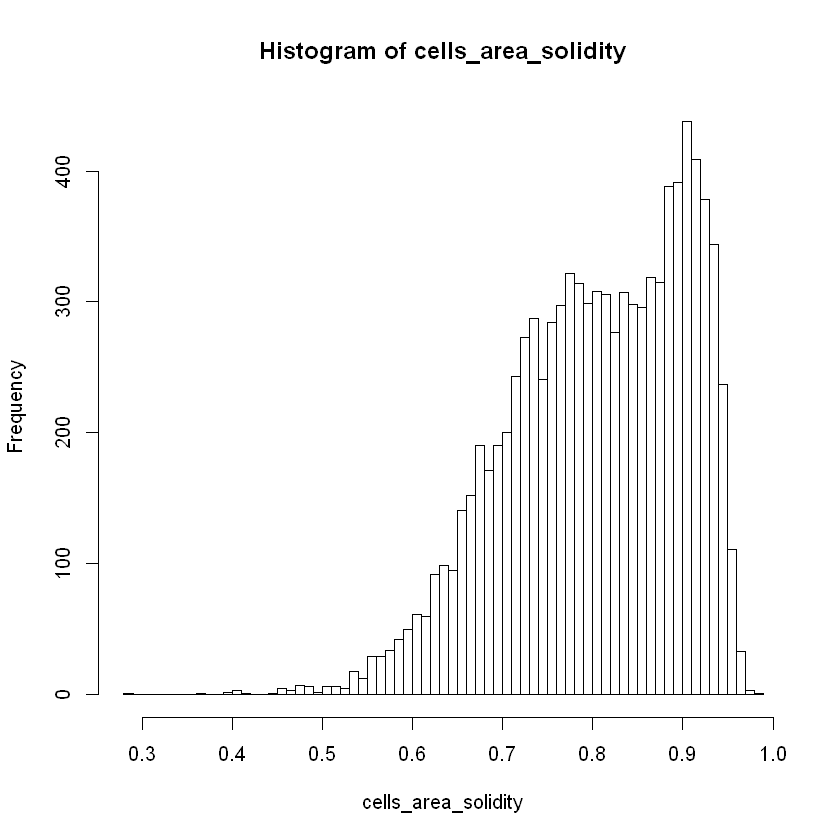

In [49]:
cells_area_solidity<-cells$AreaShape_Solidity
hist(cells_area_solidity, breaks=100)

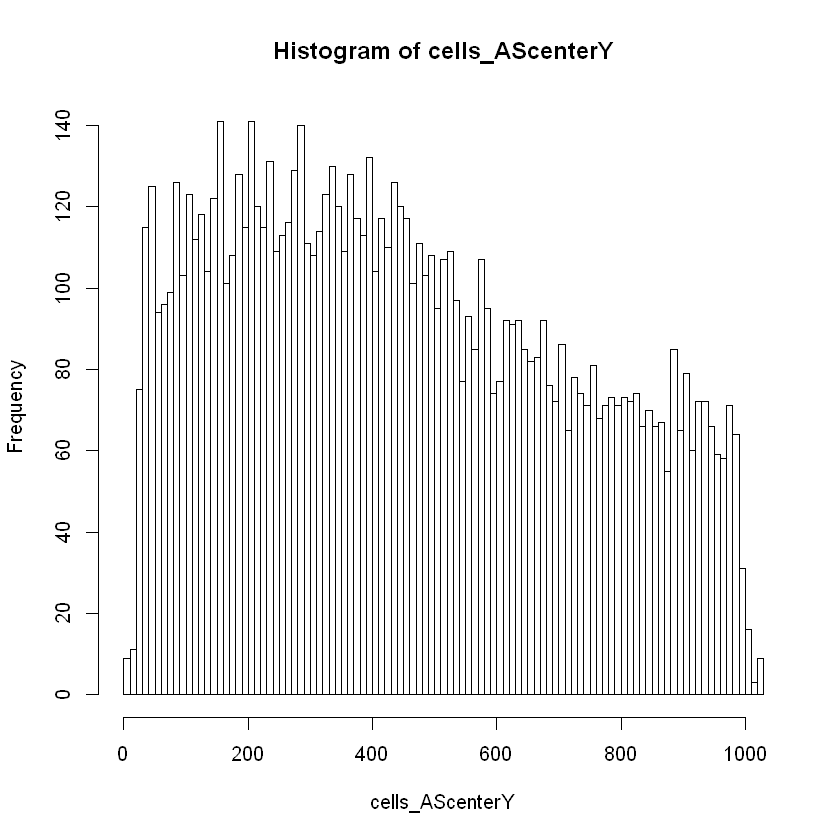

In [51]:
cells_AScenterY<-cells$AreaShape_Center_Y
hist(cells_AScenterY, breaks=100)

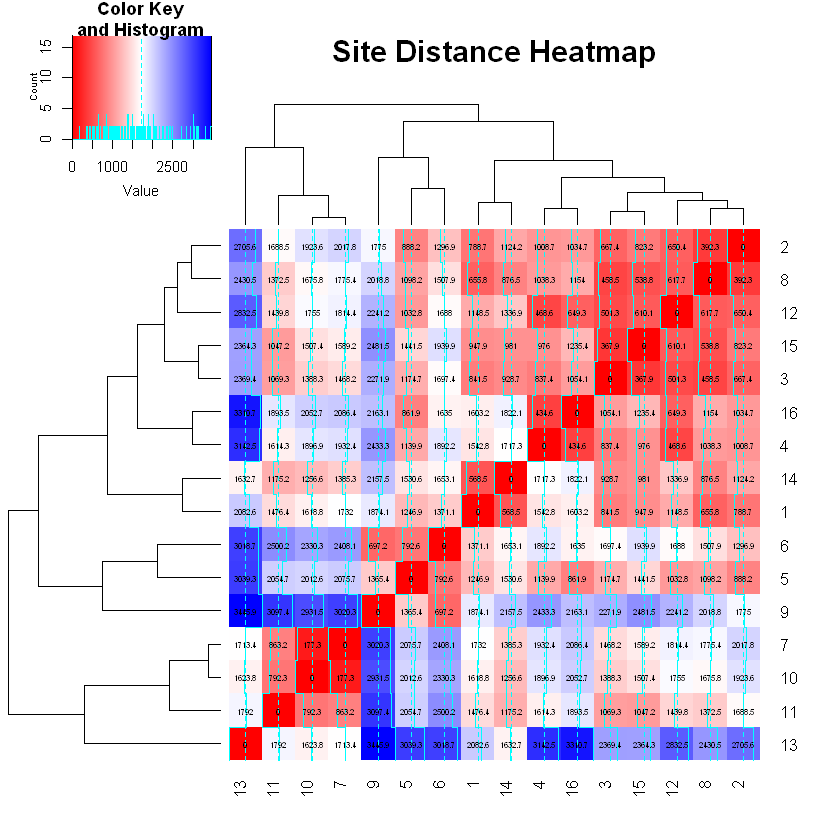

In [62]:
#create distance matrix and heatmap of cell feature means
dists <- dist(cells_mean)
dists<- as.matrix(dists)
dists<-round(dists, 1)
heatmap.2(dists, col = colorpanel(1000, "red", "white", "blue"),  margins=c(4,4), cellnote=dists,
          notecex=0.5, notecol="black",na.color=par("bg"), main= "Site Distance Heatmap")

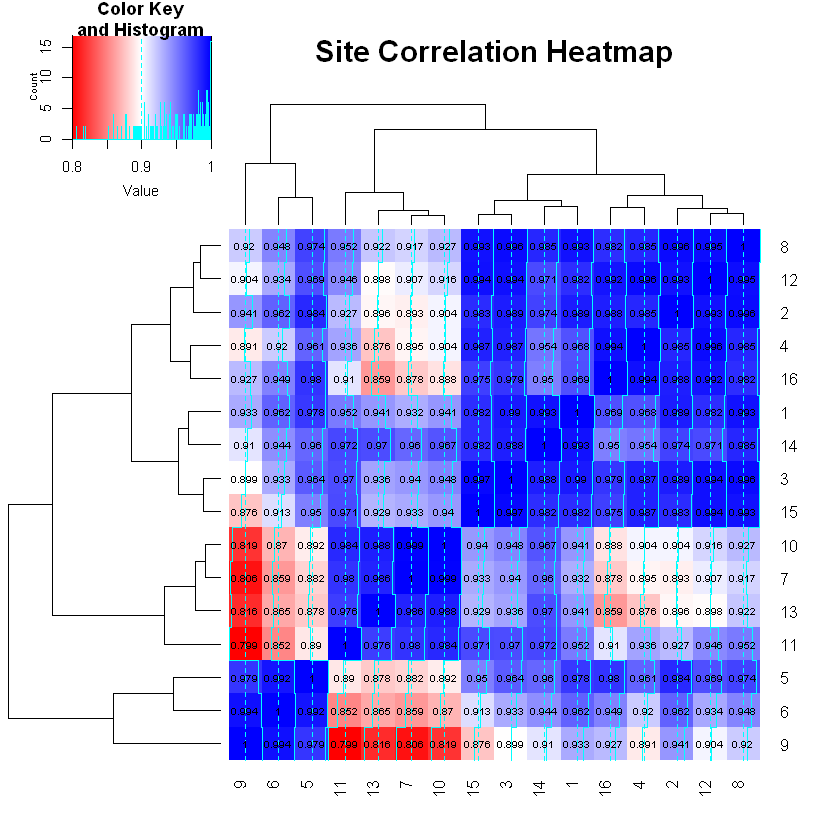

In [63]:
#create correlation matrix and heatmap of cell feature means
corr<-cor(t(cells_mean))
corr<-round(as.matrix(corr),3)
heatmap.2(corr, col = colorpanel(1000, "red", "white", "blue"),  margins=c(4,4), cellnote=corr,         
          notecex=0.6, notecol="black",na.color=par("bg"), main= "Site Correlation Heatmap")

In [65]:
#running Shapiro-Wilks test
shapiro_control<-shapiro2(control_cells[0:5000,], 0.0000000005)

Warning message in cor(DMSO_cells, y):
"the standard deviation is zero"

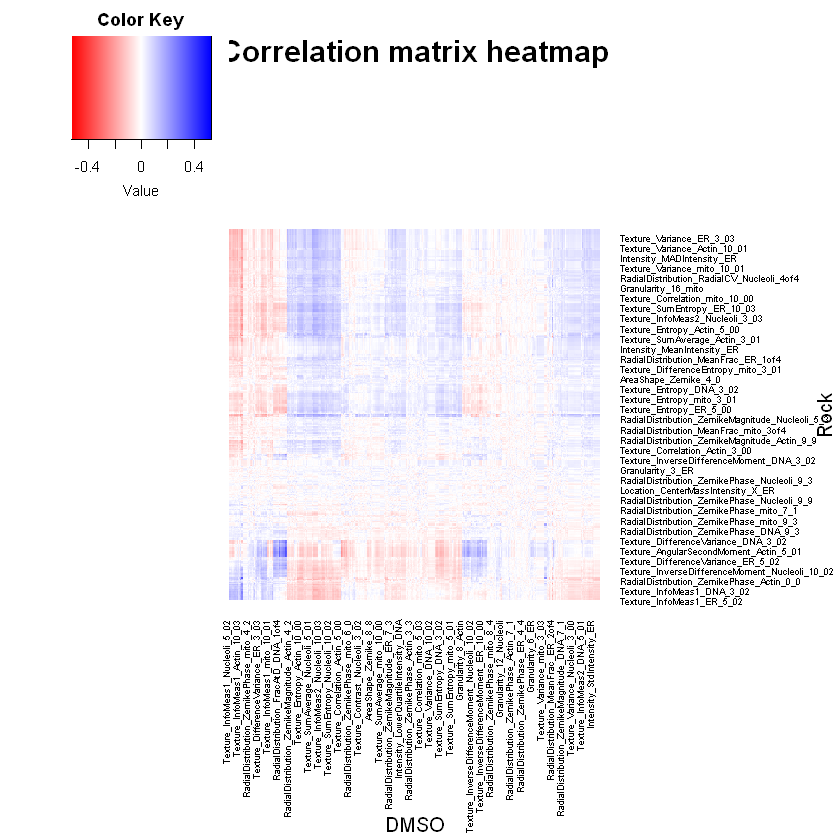

In [70]:
# to create a heatmap of a correlation matrix: 
y<- average(DMSO_cells, Rock_cells)
corr<-cor(DMSO_cells, y)
corr<-corr[rowSums(is.na(corr))<ncol(corr)*0.5,colSums(is.na(corr))<nrow(corr)*0.5]
p<- heatmap.2(corr, scale = "none", dendrogram='none', Rowv=TRUE, Colv=TRUE, 
              col = colorpanel(1000, "red", "white", "blue"), trace = "none", density.info = "none", 
              xlab="DMSO", ylab="Rock", main= "Correlation matrix heatmap", margins = c(12,12))

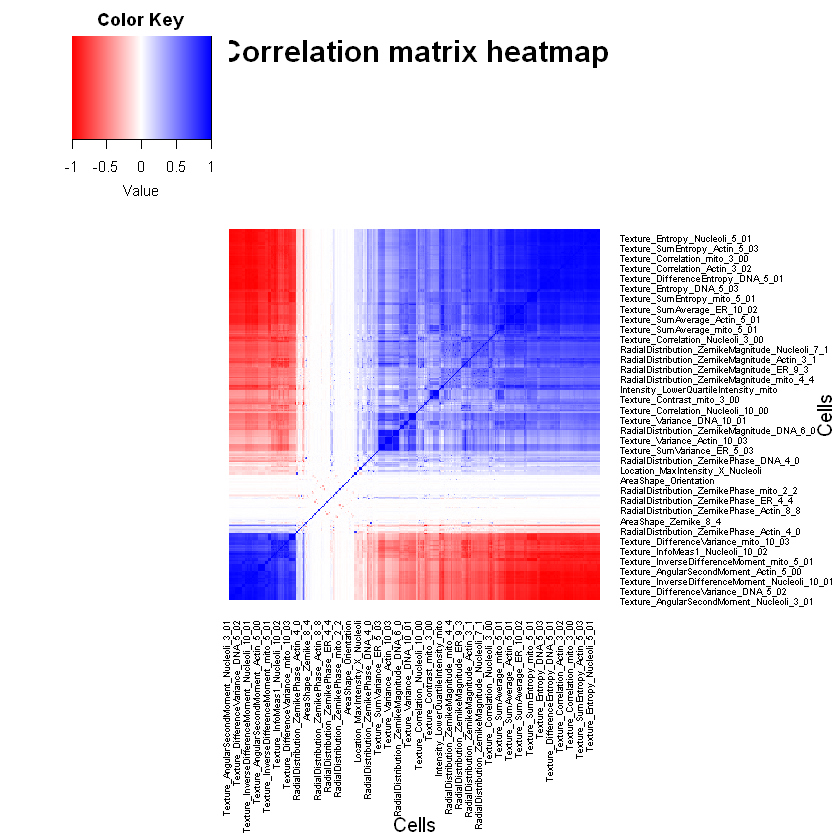

In [72]:
corr<-cor(cells)
corr<-corr[rowSums(is.na(corr))<ncol(corr)*0.5,colSums(is.na(corr))<nrow(corr)*0.5]
p<- heatmap.2(corr, scale = "none", dendrogram='none', Rowv=TRUE, Colv=TRUE, 
              col = colorpanel(1000, "red", "white", "blue"), trace = "none", density.info = "none", 
              xlab="Cells", ylab="Cells", main= "Correlation matrix heatmap", margins = c(12,12))

In [ ]:
#export correlation matrix
write.csv(corr,"C:\\Users\\xinli\\Desktop\\RockvsDMSO.csv", row.names = TRUE)

In [73]:
#separate dataframes based on features
indx <- grepl('Area', colnames(cells))
cell_shape_features<-cells[indx]

indx<- grepl('Texture',colnames(cells))
cell_texture_features<-cells[indx]

indx<-grepl('Intensity', colnames(cells))
indx2<-grepl('Radial',colnames(cells))
cell_intensity_features<-cbind(cells[indx2],cells[indx])

indx<-grepl('Neighbor', colnames(cells))
cell_microenvironment_features<-cells[indx]

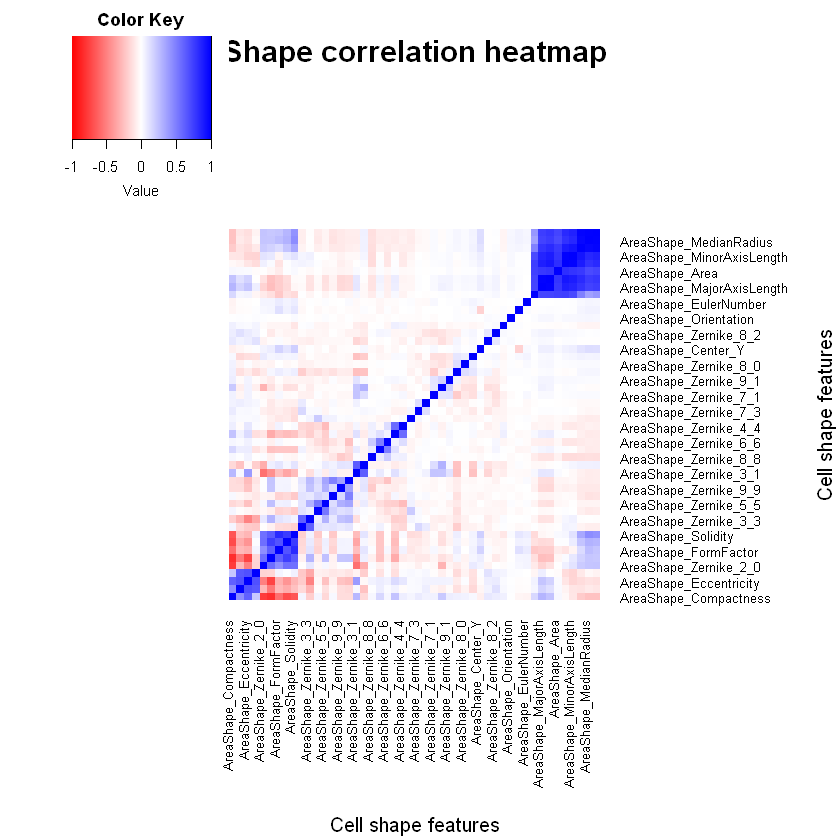

In [75]:
#construct correlation matrices and heatmaps to compare features within specific categories 
corr<-cor(cell_shape_features)
corr<-corr[rowSums(is.na(corr))<ncol(corr)*0.5,colSums(is.na(corr))<nrow(corr)*0.5]
p<- heatmap.2(corr, scale = "none", dendrogram='none', Rowv=TRUE, Colv=TRUE, 
              col = colorpanel(1000, "red", "white", "blue"), trace = "none", density.info = "none", 
              xlab="Cell shape features", ylab="Cell shape features", main= "Shape correlation heatmap", margins = c(12,12))

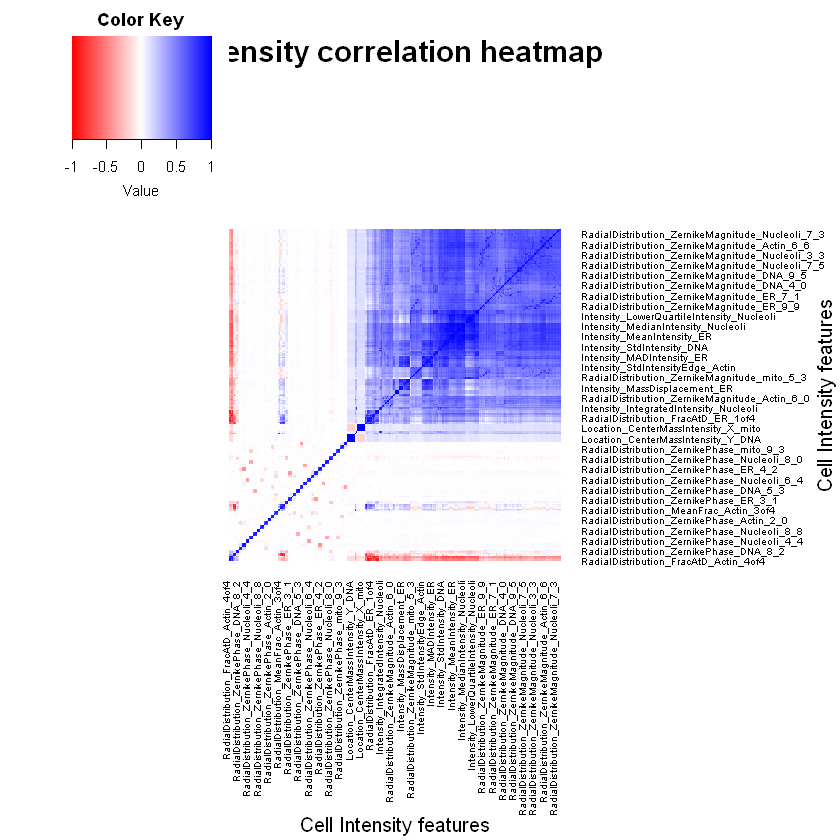

In [76]:
corr<-cor(cell_intensity_features)
corr<-corr[rowSums(is.na(corr))<ncol(corr)*0.5,colSums(is.na(corr))<nrow(corr)*0.5]
p<- heatmap.2(corr, scale = "none", dendrogram='none', Rowv=TRUE, Colv=TRUE, 
              col = colorpanel(1000, "red", "white", "blue"), trace = "none", density.info = "none", 
              xlab="Cell Intensity features", ylab="Cell Intensity features", main= "Intensity correlation heatmap", 
              margins = c(14,14))

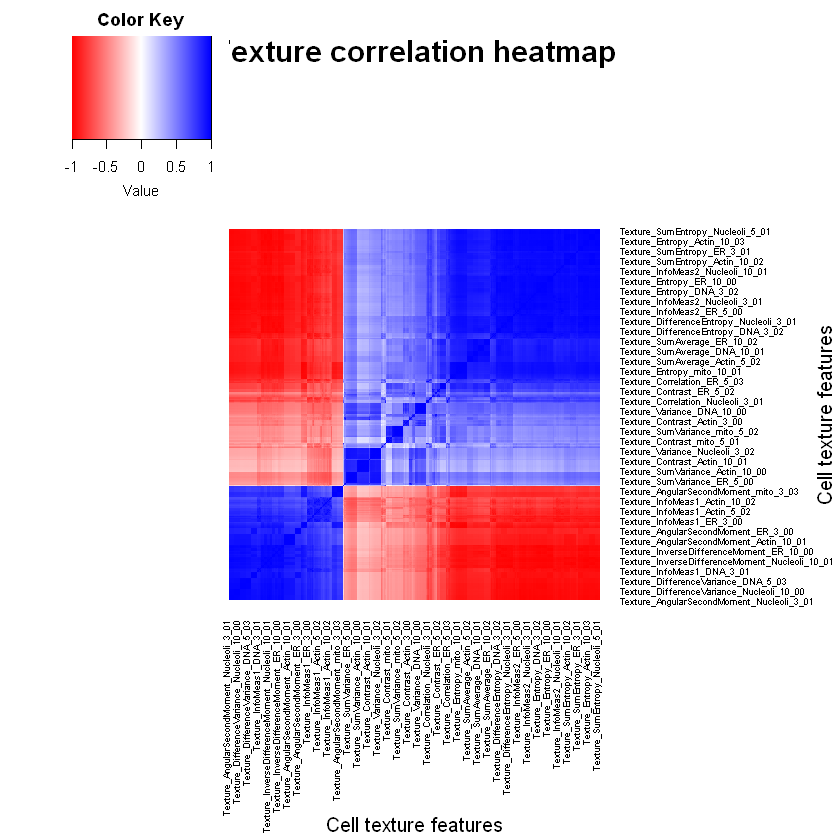

In [77]:
corr<-cor(cell_texture_features)
corr<-corr[rowSums(is.na(corr))<ncol(corr)*0.5,colSums(is.na(corr))<nrow(corr)*0.5]
p<- heatmap.2(corr, scale = "none", dendrogram='none', Rowv=TRUE, Colv=TRUE, 
              col = colorpanel(1000, "red", "white", "blue"), trace = "none", density.info = "none", 
              xlab="Cell texture features", ylab="Cell texture features", main= "Texture correlation heatmap", 
              margins = c(12,12))

In [82]:
#separate cell features based on wavelength
indx<- grepl('mito',colnames(cells))
cell_mito_features<-cells[indx]
indx<-grepl('DNA', colnames(cells))
cell_DNA_features<- cells[indx]
indx<- grepl('Actin',colnames(cells))
cell_actin_features<-cells[indx]
indx<-grepl('Nucleoli', colnames(cells))
cell_nucleoli_features<- cells[indx]
indx<- grepl('ER',colnames(cells))
cell_ER_features<-cells[indx]

In [83]:
#separate nuclei features based on wavelength
indx<- grepl('mito',colnames(nuclei))
nuc_mito_features<-nuclei[indx]
indx<-grepl('DNA', colnames(nuclei))
nuc_DNA_features<- nuclei[indx]
indx<- grepl('Actin',colnames(nuclei))
nuc_actin_features<-nuclei[indx]
indx<-grepl('Nucleoli', colnames(nuclei))
nuc_nucleoli_features<- nuclei[indx]
indx<- grepl('ER',colnames(nuclei))
nuc_ER_features<-nuclei[indx]

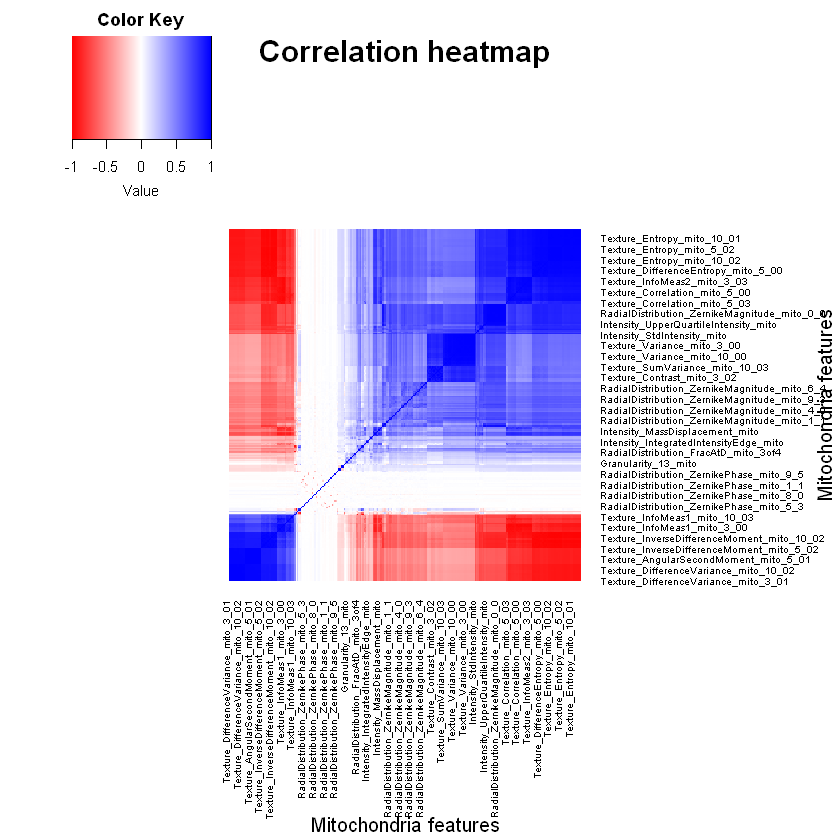

In [87]:
#construct correlation matrices and heatmaps to compare different wavelengths
corr<-cor(cell_mito_features)
corr<-corr[rowSums(is.na(corr))<ncol(corr)*0.5,colSums(is.na(corr))<nrow(corr)*0.5]
p<- heatmap.2(corr, scale = "none", dendrogram='none', Rowv=TRUE, Colv=TRUE, 
              col = colorpanel(1000, "red", "white", "blue"), trace = "none", density.info = "none", 
              xlab="Mitochondria features", ylab="Mitochondria features", main= "Correlation heatmap", 
              margins = c(13,13))

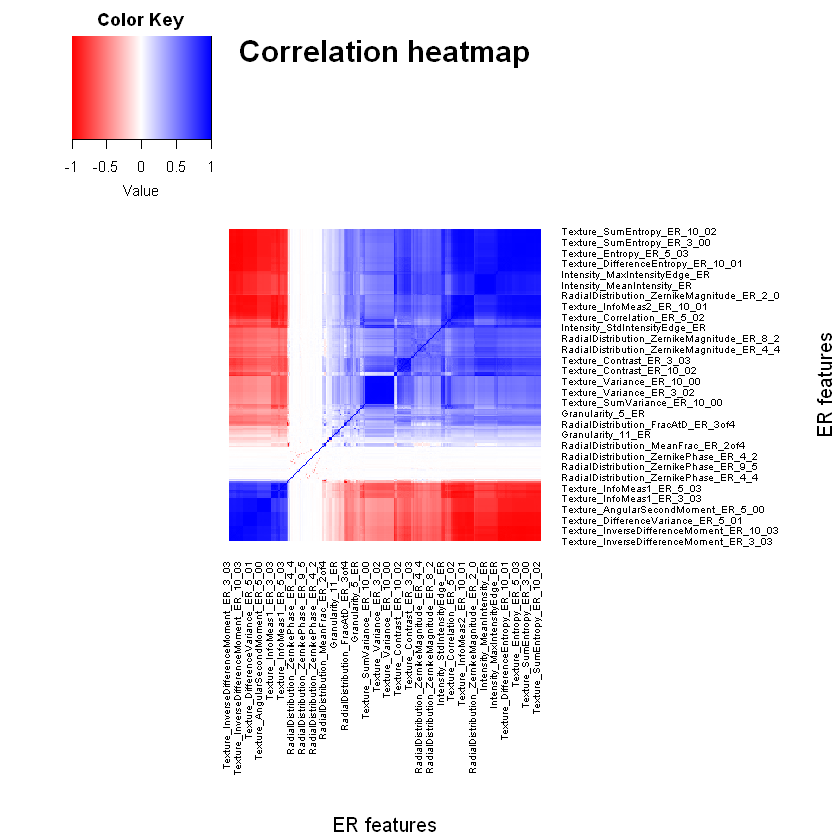

In [88]:
corr<-cor(cell_ER_features)
corr<-corr[rowSums(is.na(corr))<ncol(corr)*0.5,colSums(is.na(corr))<nrow(corr)*0.5]
p<- heatmap.2(corr, scale = "none", dendrogram='none', Rowv=TRUE, Colv=TRUE, 
              col = colorpanel(1000, "red", "white", "blue"), trace = "none", density.info = "none", 
              xlab="ER features", ylab="ER features", main= "Correlation heatmap", 
              margins = c(15,15))

In [89]:
#separate image data based on metadata
Count<-images[,c(1:9,15:17,126)]
Count<- aggregate(.~Metadata_PositionY, FUN=mean, data=Count)
Count[,"Nuc_Cyto"] <- Count[,4]/Count[,3]

Count<-Count%>% replace(Count=="8", "CHIR")
Count<-Count%>% replace(Count=="9", "Rock Inhibitor")
Count<-Count%>% replace(Count=="10", "DMSO")
Count<-Count%>% replace(Count=="7", "IWP")
Count<-Count%>% replace(Count=="11", "control")

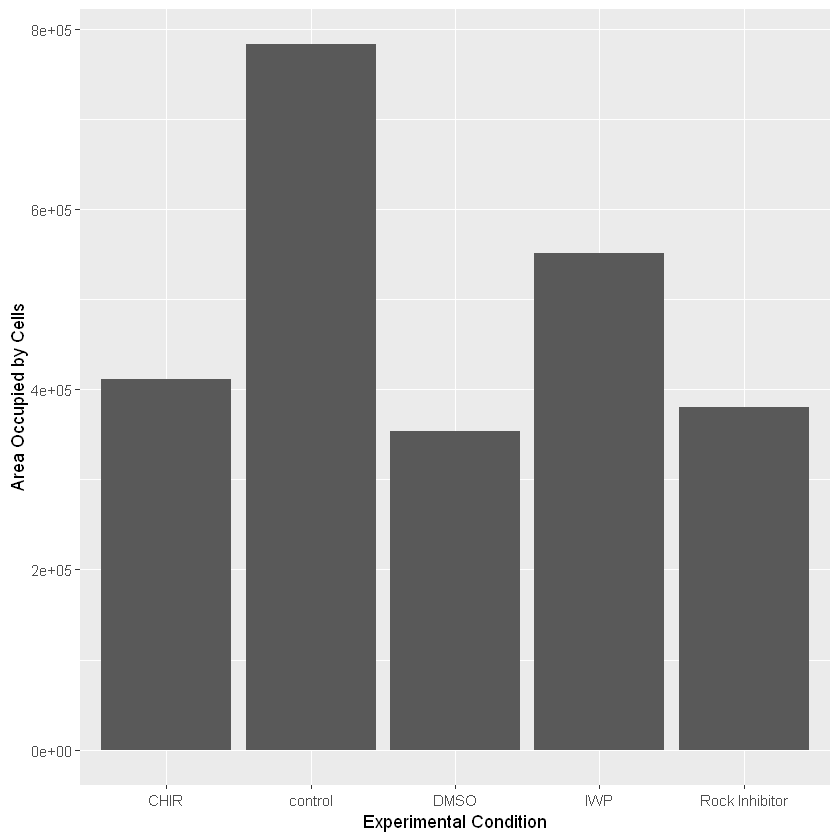

In [90]:
#plot bar graphs to compare average of features extracted from image data
ggplot(Count, aes(x=Metadata_PositionY, y=AreaOccupied_AreaOccupied_Cells)) + geom_bar(stat="identity") + 
  labs(x="Experimental Condition", y="Area Occupied by Cells", main="Area Occupied vs Experimental Condition")

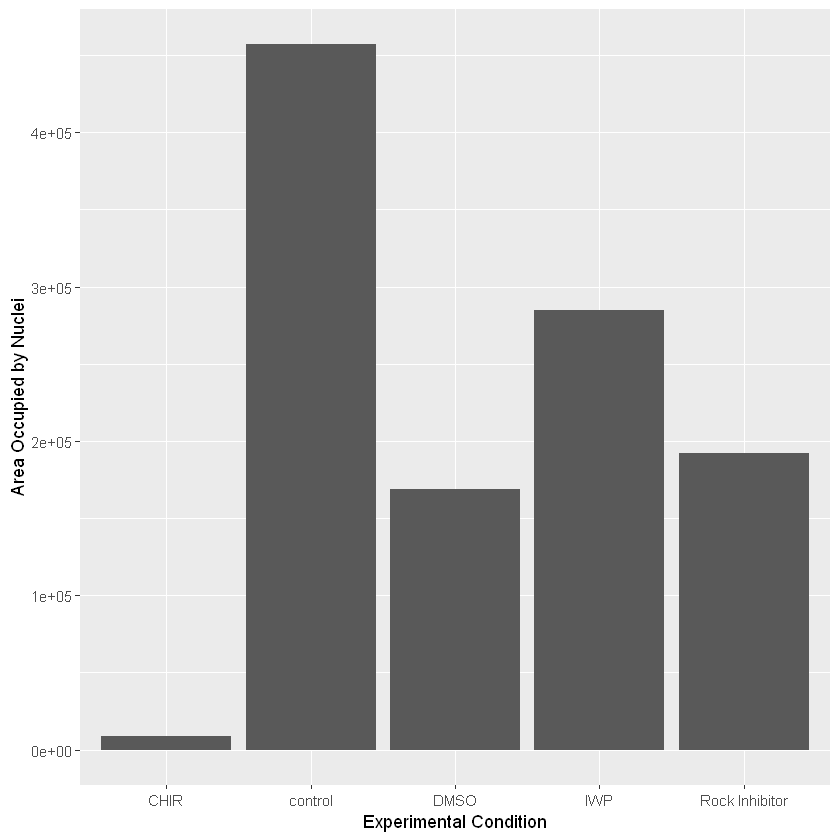

In [91]:
ggplot(Count, aes(x=Metadata_PositionY, y=AreaOccupied_AreaOccupied_Nuclei)) + geom_bar(stat="identity") + 
  labs(x="Experimental Condition", y="Area Occupied by Nuclei")

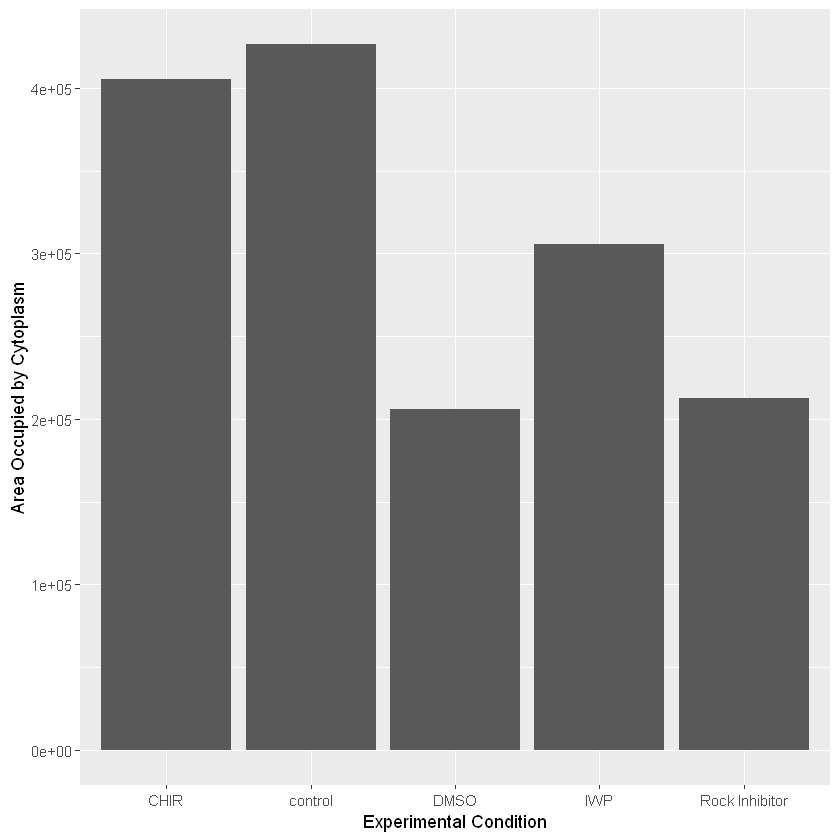

In [92]:
ggplot(Count, aes(x=Metadata_PositionY, y=AreaOccupied_AreaOccupied_Cytoplasm)) + geom_bar(stat="identity") + 
  labs(x="Experimental Condition", y="Area Occupied by Cytoplasm")

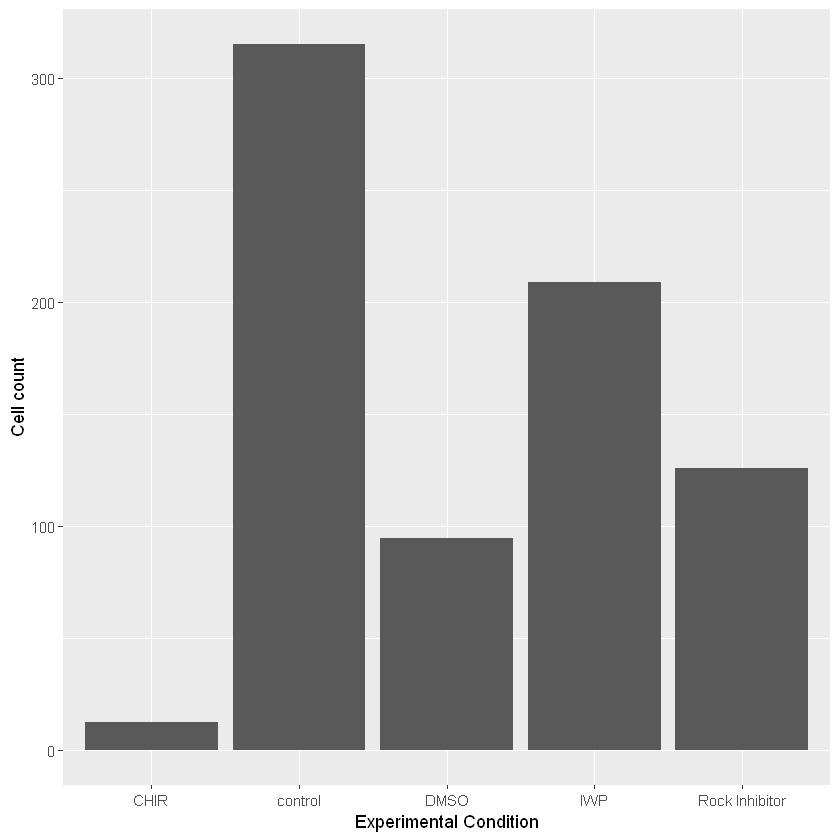

In [93]:
ggplot(Count, aes(x=Metadata_PositionY, y=Count_Cells)) + geom_bar(stat="identity") + 
  labs(x="Experimental Condition", y="Cell count")

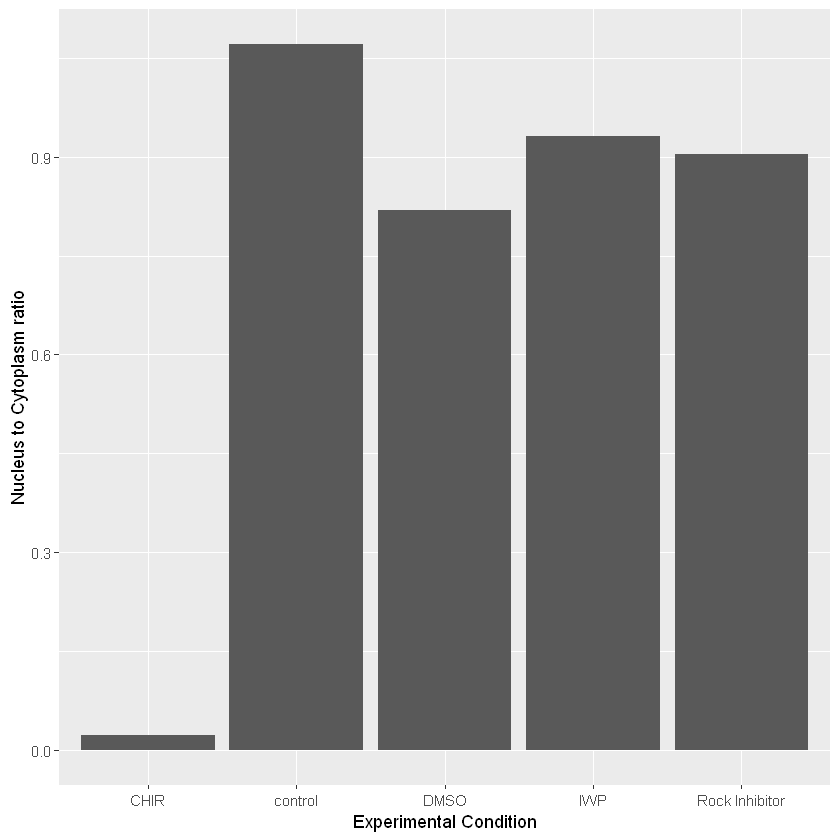

In [94]:
ggplot(Count, aes(x=Metadata_PositionY, y=Nuc_Cyto)) + geom_bar(stat="identity") + 
  labs(x="Experimental Condition", y="Nucleus to Cytoplasm ratio")

In [ ]:
CHIR_images<-images%>%
  filter(Metadata_PositionY==8)
DMSO_images<-images%>%
  filter(Metadata_PositionY==10)
control_images<-images%>%
  filter(Metadata_PositionY==11)

images_area <-CHIR_images$AreaOccupied_AreaOccupied_Nuclei
hist(images_area, breaks=100)

control_area<-control_images$AreaOccupied_AreaOccupied_Nuclei
hist(control_area, breaks=6)
nuclei_intensity<-nuclei$Intensity_MinIntensity_Actin
hist(nuclei_intensity, breaks=200)

In [ ]:
#export dataframe 
write.csv(corr,"C:\\Users\\xinli\\Desktop\\MyData.csv", row.names = FALSE)

In [ ]:
#construct distance matrix
cells_matrix<-matrix(as.numeric(unlist(cells[,-1])),nrow=nrow(cells))
nuclei_matrix<-matrix(as.numeric(unlist(nuclei)),nrow=nrow(nuclei))
cytoplasm_matrix<-matrix(as.numeric(unlist(cytoplasm)),nrow=nrow(cytoplasm))

In [ ]:
DMSO_cells_matrix<-matrix(as.numeric(unlist(DMSO_cells)),nrow=nrow(DMSO_cells))
control_cells_matrix<-matrix(as.numeric(unlist(control_cells)),nrow=nrow(control_cells))
DMSO_nuclei_matrix<-matrix(as.numeric(unlist(DMSO_nuclei)),nrow=nrow(DMSO_nuclei))
control_nuclei_matrix<-matrix(as.numeric(unlist(control_nuclei)),nrow=nrow(control_nuclei))

In [ ]:
ex<-as.data.frame(colnames(cells))
write.csv(ex,"C:\\Users\\xinli\\Desktop\\Features.csv", row.names = FALSE)

In [ ]:
#calculate control feature-feature correlation matrix
corr_cells<-cor(control_cells)
corr_cells<-corr_cells[-2,-2]
dists <- pdist(t(DMSO_cells), t(control_cells))
dists<- as.matrix(dists)
heatmap.2(dists, Colv=NA, Rowv=NA, col=cm.colors(256), scale="row", margins=c(3,3), xlab= "DMSO", ylab="Control",
          main= "Feature-Feature Correlation Heatmap")        